# Waste-Assist Classification using ResNet

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.saved_model import load
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub


"""Leave this in for Google Collab"""
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

## Import the ResNet Model

In [3]:
# resnet = models.load_model('../models/resnet')

# resnet = tensorflow.keras.Sequential([
#     hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5")
# ])
def initialise_model():
  resnet = tensorflow.keras.applications.resnet_v2.ResNet152V2(
      include_top=False, weights='imagenet',
      input_shape=(256,256,3)
                                      )
  resnet.trainable = False
  inputs = tensorflow.keras.Input(shape=(256, 256, 3))
  # We make sure that the base_model is running in inference mode here,
  # by passing `training=False`. This is important for fine-tuning, as you will
  # learn in a few paragraphs.
  x = resnet(inputs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tensorflow.keras.layers.Dense(7, activation='softmax')(x)
  model = tensorflow.keras.Model(inputs, outputs)
  return model

# base_model = keras.applications.Xception(
#     weights='imagenet',  # Load weights pre-trained on ImageNet.
#     input_shape=(150, 150, 3),
#     include_top=False)  # Do not include the ImageNet classifier at the top.

# resnet_model = tensorflow.keras.Sequential([
#     resnet,
#     tensorflow.layers.Dense(7, 
# ])

In [32]:
resnet = initialise_model()

In [33]:
# Check its architecture
resnet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 58,345,991
Trainable params: 14,343
Non-trainable params: 58,331,648
_________________________________________________________________


#1st Method - generating different augmented images each epoch (not saving images)

## Preprocessing the Training set

In [4]:
!gsutil -m cp -r "gs://waste-assist-batch665/data" . 

Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8367.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8376.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8429.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8422.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8427.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8444.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8448.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8489.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8501.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8505.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/IMG_8507.jpeg...
Copying gs://waste-assist-batch665/data/test/cardboard/cardboard108.jpg...
Copying gs://waste-assist-batch665/data/test/cardboard/cardboard114.jpg...
Copying gs://waste-assist-batch665/data/test/cardboard/car

In [ ]:
# bucket_name = 'waste-assist-batch665'
# prefix = '/data/train/'
# dl_dir = '/home/eugene/code/evgenfsf/waste-assist/raw_data/train' #change this in google Colab

# storage_client = storage.Client()
# bucket = storage_client.get_bucket(bucket_name)
# blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
# for blob in blobs:
#     filename = blob.name.replace('/', '_') 
#     blob.download_to_filename(dl_dir + filename)  # Download

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.3,
                                   rotation_range=20,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split=0.1)

# tf.keras.preprocessing.image.ImageDataGenerator(
#     featurewise_center=False, samplewise_center=False,
#     featurewise_std_normalization=False, samplewise_std_normalization=False,
#     zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
#     height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
#     channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
#     horizontal_flip=False, vertical_flip=False, rescale=None,
#     preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
# )
drive_dir = '/content/drive/MyDrive/waste_assist'
local_dir = './data'
X_train_gen = train_datagen.flow_from_directory(
        f'{local_dir}/train',
         target_size = (256, 256),
         batch_size = 32,
         class_mode = 'categorical',
         subset = 'training')

X_val_gen = train_datagen.flow_from_directory(
        f'{local_dir}/train',
        target_size=(256, 256),
        batch_size=8,
        class_mode='categorical',
        subset = 'validation')
# flow_from_directory(
#     directory, target_size=(256, 256), color_mode='rgb', classes=None,
#     class_mode='categorical', batch_size=32, shuffle=True, seed=None,
#     save_to_dir=None, save_prefix='', save_format='png',
#     follow_links=False, subset=None, interpolation='nearest'
# )


Found 2162 images belonging to 7 classes.
Found 236 images belonging to 7 classes.


In [5]:
X_train_gen.class_indices

{'cardboard': 0,
 'compost': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

## Preprocessing the Test set

In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)
X_test_gen = test_datagen.flow_from_directory(f'{local_dir}/test',
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 616 images belonging to 7 classes.


In [ ]:
X_test_gen.class_indices

{'cardboard': 0,
 'compost': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

##Double checking the generator creates copies of images

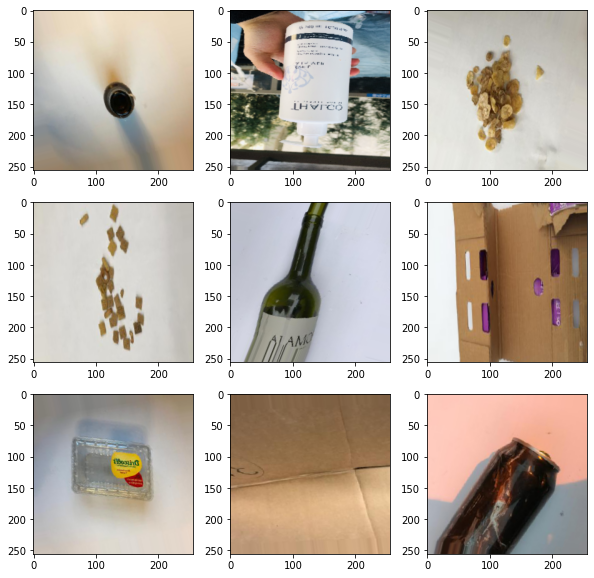

In [7]:
plt.figure(figsize=(10,10))
# generate samples and plot
X_train_gen.reset()
batch = X_train_gen.next()
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(batch[0][i])

X_train_gen.reset()
# show the figure
plt.show()

# Training the ResNet

In [8]:
from tensorflow.keras import optimizers

def compile_model(model):
    '''return a compiled model suited for the task'''
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics='accuracy')
    return model

In [9]:
resnet = initialise_model()
resnet = compile_model(resnet)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

baseline = 1/7 # select at random from 7 categories

es = EarlyStopping(patience=10, verbose=2, restore_best_weights=True, monitor='val_accuracy')

In [10]:
import os
checkpoint_path = f"{drive_dir}/resnet/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, 
                                                 verbose=1, monitor= 'val_accuracy',
                                                save_best_only=True, mode='max', 
                                                )



In [12]:
history = resnet.fit(x=X_train_gen,
                    validation_data=X_val_gen,
                    callbacks=[cp_callback, es],  
                    epochs=100, 
                    batch_size=32,
                    use_multiprocessing=True,
                   )

Epoch 1/100
68/68 [==============================] - 104s 1s/step - loss: 1.0404 - accuracy: 0.6337 - val_loss: 0.7100 - val_accuracy: 0.7458

Epoch 00001: val_accuracy improved from -inf to 0.74576, saving model to /content/drive/MyDrive/waste_assist/resnet/cp.ckpt
Epoch 2/100
68/68 [==============================] - 81s 1s/step - loss: 0.5938 - accuracy: 0.7965 - val_loss: 0.6744 - val_accuracy: 0.7161

Epoch 00002: val_accuracy did not improve from 0.74576
Epoch 3/100
68/68 [==============================] - 81s 1s/step - loss: 0.4976 - accuracy: 0.8298 - val_loss: 0.6560 - val_accuracy: 0.7373

Epoch 00003: val_accuracy did not improve from 0.74576
Epoch 4/100
68/68 [==============================] - 81s 1s/step - loss: 0.4381 - accuracy: 0.8520 - val_loss: 0.6310 - val_accuracy: 0.7458

Epoch 00004: val_accuracy did not improve from 0.74576
Epoch 5/100
68/68 [==============================] - 80s 1s/step - loss: 0.4044 - accuracy: 0.8608 - val_loss: 0.8340 - val_accuracy: 0.7203



In [13]:
resnet.save(f'{drive_dir}/resnet_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/waste_assist/resnet_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

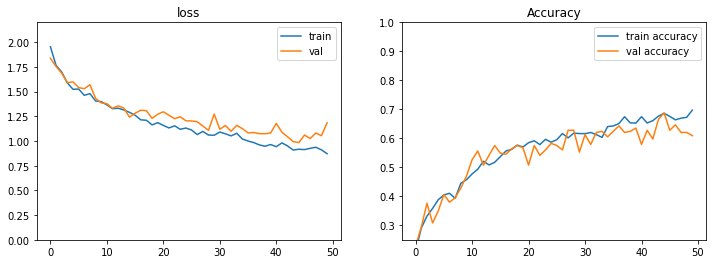

In [ ]:
plot_history(history)
plt.show()

# Prediction

In [12]:
checkpoint_path

'/content/drive/MyDrive/waste_assist/resnet/cp.ckpt'

In [14]:
resnet = initialise_model()
resnet = compile_model(resnet)
resnet.load_weights(checkpoint_path)

In [15]:
resnet.evaluate(x=X_test_gen)

20/20 [==============================] - 49s 791ms/step - loss: 0.4597 - accuracy: 0.8393


[0.45966389775276184, 0.8392857313156128]

#2nd Method - save the augmented images and use them 

In [ ]:
train_datagen2 = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.3,
                                   rotation_range=25,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split=0.1,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                                          )

# tf.keras.preprocessing.image.ImageDataGenerator(
#     featurewise_center=False, samplewise_center=False,
#     featurewise_std_normalization=False, samplewise_std_normalization=False,
#     zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
#     height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
#     channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
#     horizontal_flip=False, vertical_flip=False, rescale=None,
#     preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
# )
drive_dir = '/content/drive/MyDrive/waste_assist'
local_dir = '../raw_data'
X_train_gen_save = train_datagen2.flow_from_directory(
        f'{drive_dir}/training',
         target_size = (256, 256),
         batch_size = 32,
         class_mode = 'categorical',
         subset = 'training',
         save_to_dir = f'{drive_dir}/augmented',
         save_prefix = 'augmented',
         save_format = 'jpg')

# X_val_gen_save = train_datagen.flow_from_directory(
#         f'{drive_dir}/training',
#         target_size=(256, 256),
#         batch_size=8,
#         class_mode='categorical',
#         subset = 'validation')
# flow_from_directory(
#     directory, target_size=(256, 256), color_mode='rgb', classes=None,
#     class_mode='categorical', batch_size=32, shuffle=True, seed=None,
#     save_to_dir=None, save_prefix='', save_format='png',
#     follow_links=False, subset=None, interpolation='nearest'
# )
